# Graduate Admission 2

### This notebook predicts the probability of a student being admitted to a university based on a set of features.
### The sequential ANN model from Keras is used as the base model

Data: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping


print(tf.__version__)
print(keras.__version__)

C:\Users\DLP\AppData\Local\Temp\ipykernel_24272\2430681950.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



2.15.0
2.15.0


In [2]:
df = pd.read_csv("Admission_Predict_Ver1_1.csv") # "Admission_Predict.csv", "Admission_Predict_Ver1_1.csv"
display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


None

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


# Drop Serial No. column

In [3]:
df.drop(columns=['Serial No.'], inplace=True)
display(df.head(5))

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


# Use the StandardScaler on all Features except Research and Chance of Admit

In [4]:
df_scaled = df.copy()
for idx, column_name in enumerate(df_scaled.columns):
    if idx < len(df_scaled.columns)-2:
        print(column_name)
        df_scaled[[column_name]] = StandardScaler().fit_transform(df_scaled[[column_name]].to_numpy())

display(df_scaled.head(5))

GRE Score
TOEFL Score
University Rating
SOP
LOR 
CGPA


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,1,0.92
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,1,0.76
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,1,0.72
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,1,0.80
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,0,0.65


# Partition data into Training, Validation and Test sets

In [5]:
X = df_scaled.iloc[:,0:-1].to_numpy()
y = df_scaled.iloc[:,-1].to_numpy()
print("Nr. Features: ", X.shape[1])

Nr. Features:  7


In [6]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=0)
X_train_valid = np.concatenate([X_train,X_valid])
y_train_valid = np.concatenate([y_train,y_valid])

# Explore the training, validationand test sets

Text(0.5, 1.0, 'Nr. Samples')

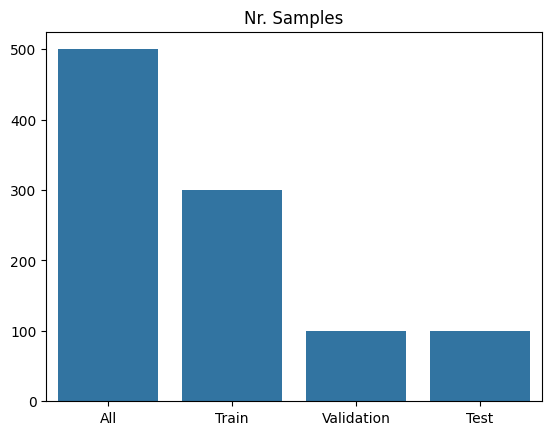

In [7]:
sns.barplot(x=["All","Train","Validation","Test"], y=[X.shape[0], X_train.shape[0], X_valid.shape[0], X_test.shape[0]])
plt.title("Nr. Samples")

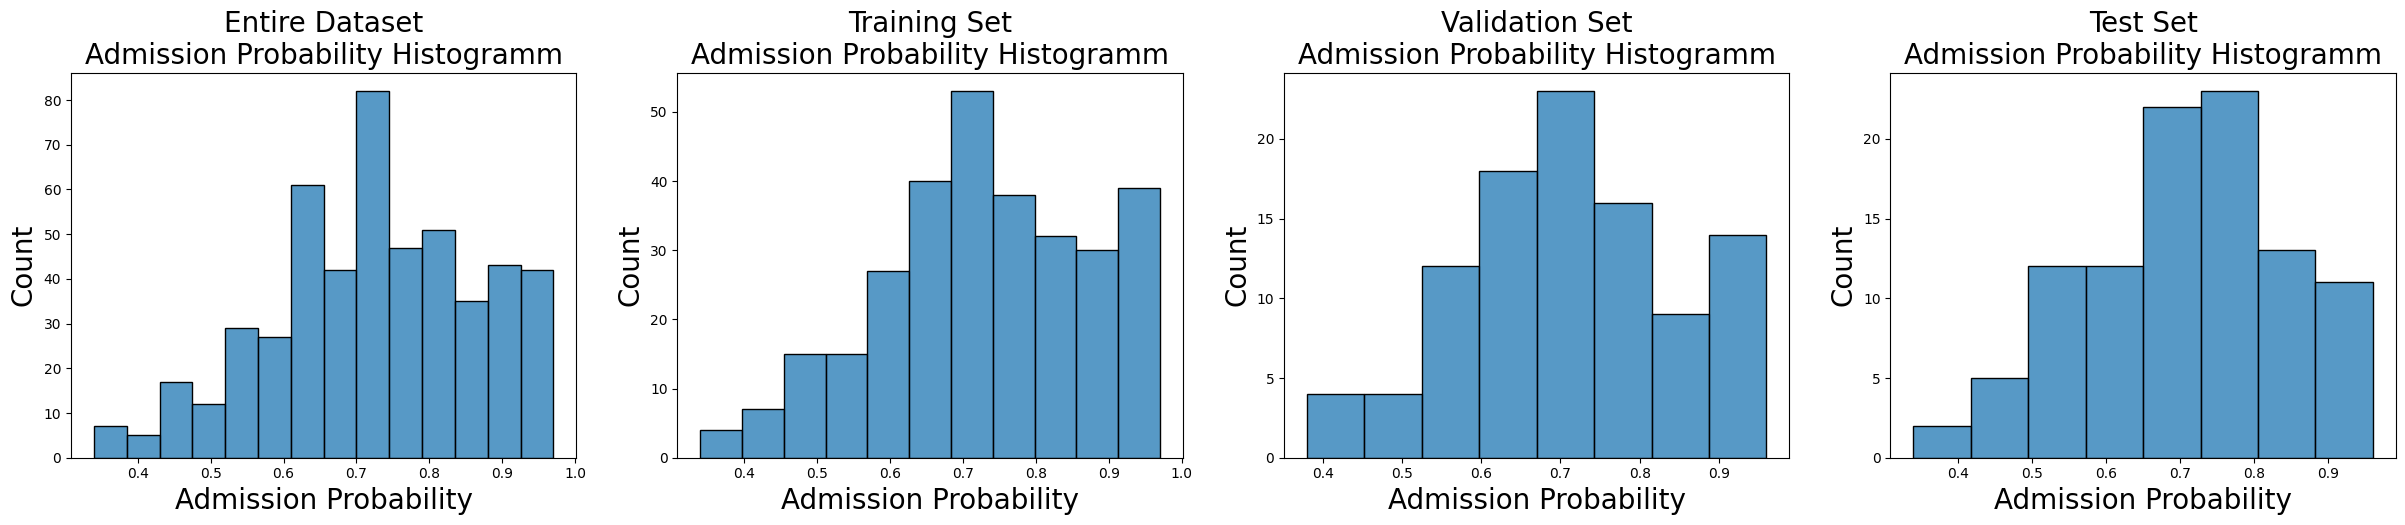

In [8]:
f, axes = plt.subplots(1, 4, figsize=(30, 5))
ax_idx = 0
sns.histplot(data=y, ax=axes[ax_idx])
axes[0].set_title("Entire Dataset\nAdmission Probability Histogramm", fontsize=20)
axes[0].set_xlabel("Admission Probability", fontsize=20)
axes[0].set_ylabel("Count", fontsize=20)
ax_idx+=1

sns.histplot(data=y_train, ax=axes[ax_idx])
axes[ax_idx].set_title("Training Set\nAdmission Probability Histogramm", fontsize=20)
axes[ax_idx].set_xlabel("Admission Probability", fontsize=20)
axes[ax_idx].set_ylabel("Count", fontsize=20)
ax_idx+=1

sns.histplot(data=y_valid, ax=axes[ax_idx])
axes[ax_idx].set_title("Validation Set\nAdmission Probability Histogramm", fontsize=20)
axes[ax_idx].set_xlabel("Admission Probability", fontsize=20)
axes[ax_idx].set_ylabel("Count", fontsize=20)
ax_idx+=1

sns.histplot(data=y_test, ax=axes[ax_idx])
axes[ax_idx].set_title("Test Set\nAdmission Probability Histogramm", fontsize=20)
axes[ax_idx].set_xlabel("Admission Probability", fontsize=20)
axes[ax_idx].set_ylabel("Count", fontsize=20)
ax_idx+=1

# Visually check for redundant and non-relevant features

<Axes: >

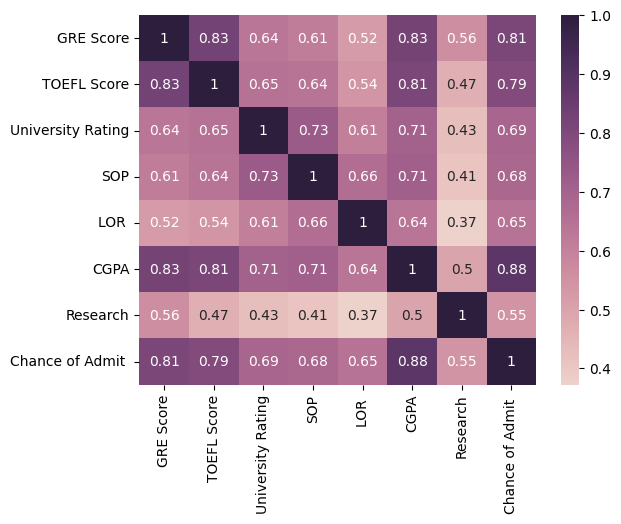

In [9]:
sns.heatmap(df_scaled.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

# Train and test different regression models

# Define objective funcions for hyperparameter tuning

In [10]:
# Objective function for hyperparameter tuning of DecisionTree
random_state = 42
def objective_dtr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
    "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
    "max_depth": trial.suggest_int("max_depth", 1, 20),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),    
    "random_state": trial.suggest_categorical("random_state", [42]),
    }
    
    model = DecisionTreeRegressor(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

In [11]:
# Objective function for hyperparameter tuning of RandomForest
random_state = 42
def objective_rfr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
    "random_state": trial.suggest_categorical("random_state", [42]),
    "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
    }
    
    model = RandomForestRegressor(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

In [12]:
# Objective function for hyperparameter tuning of Support Vector Machine
def objective_svr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "C": trial.suggest_float("C", 1e-10, 1e10, log=True),
    "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
    "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
    "max_iter": trial.suggest_categorical("max_iter", [10*1000*1000]),
    }
    
    model = SVR(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

# Train and test the regression models

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# DecisionTreeRegressor
study_dtr = optuna.create_study(direction = "maximize")
func = lambda trial: objective_dtr(trial, X_train, X_valid, y_train, y_valid)
study_dtr.optimize(func, n_trials = 100, timeout=600)
model = DecisionTreeRegressor(**study_dtr.best_trial.params).fit(X_train_valid, y_train_valid)
dectree_r2 = model.score(X_test, y_test)

# RandomForestRegressor
study_rfr = optuna.create_study(direction = "maximize")
func = lambda trial: objective_rfr(trial, X_train, X_valid, y_train, y_valid)
study_rfr.optimize(func, n_trials = 100, timeout=600)
model = RandomForestRegressor(**study_rfr.best_trial.params).fit(X_train_valid, y_train_valid)
randfor_r2 = model.score(X_test, y_test)

# SVR
study_svr = optuna.create_study(direction = "maximize")
func = lambda trial: objective_svr(trial, X_train, X_valid, y_train, y_valid)
study_svr.optimize(func, n_trials = 100, timeout=600)
model = SVR(**study_svr.best_trial.params).fit(X_train_valid, y_train_valid)
svr_r2 = model.score(X_test, y_test)

In [14]:
print("DecisionTreeRegressor R2 =", dectree_r2)
print("RandomForestRegressor Tree R2 =", randfor_r2)
print("SVR R2 =", svr_r2)

DecisionTreeRegressor R2 = 0.5259492831260479
RandomForestRegressor Tree R2 = 0.674443093511335
SVR R2 = 0.5739751636836046


# Regression with a simple ANN

In [15]:
# Parameters for ANNs
hidden_num_nodes = X_train.shape[1]*2
# Integer or None. Number of samples per gradient update
batch_size = 8
# Number of epochs to train the model. 
# An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None).
nr_epochs = 150

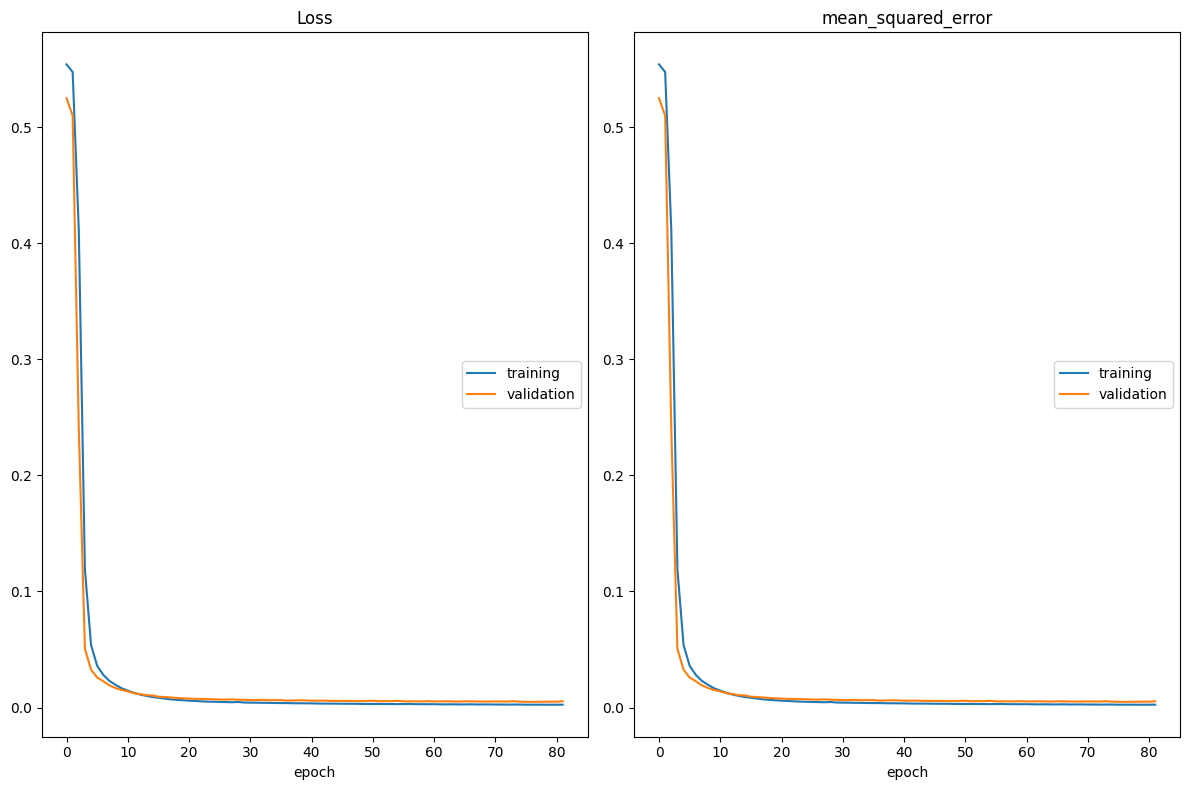

Loss
	training         	 (min:    0.002, max:    0.554, cur:    0.002)
	validation       	 (min:    0.005, max:    0.525, cur:    0.005)
mean_squared_error
	training         	 (min:    0.002, max:    0.554, cur:    0.002)
	validation       	 (min:    0.005, max:    0.525, cur:    0.005)


In [16]:
simple_ann_reg = Sequential()

# Optional
input_layer = Input(shape=(X_train.shape[1]))
simple_ann_reg.add(input_layer)

#Adding Hidden Layer
simple_ann_reg.add(Dense(units=hidden_num_nodes, activation='relu'))
#Adding Hidden Layer
simple_ann_reg.add(Dense(units=hidden_num_nodes, activation='relu'))
#Adding Output Layer
simple_ann_reg.add(Dense(units=1,activation='relu'))

# Compile the Network
simple_ann_reg.compile(optimizer = 'adam',
             loss = "mean_squared_error",
             metrics = ['mean_squared_error',])

# Train and monitor the model
es_callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=3)
simple_ann_reg.fit(X_train, y_train,
          batch_size = batch_size,
          epochs = nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[es_callback, PlotLossesKeras()],
          verbose=0)

In [17]:
predictionsANNK = simple_ann_reg.predict(X_test)
test_r2 = r2_score(y_test, predictionsANNK)
print("R2 from the simple ANN: ", test_r2)

4/4 [==============================] - 0s 2ms/step
R2 from the simple ANN:  0.6060843484687091


# Train and test the Keras ANN regressor model

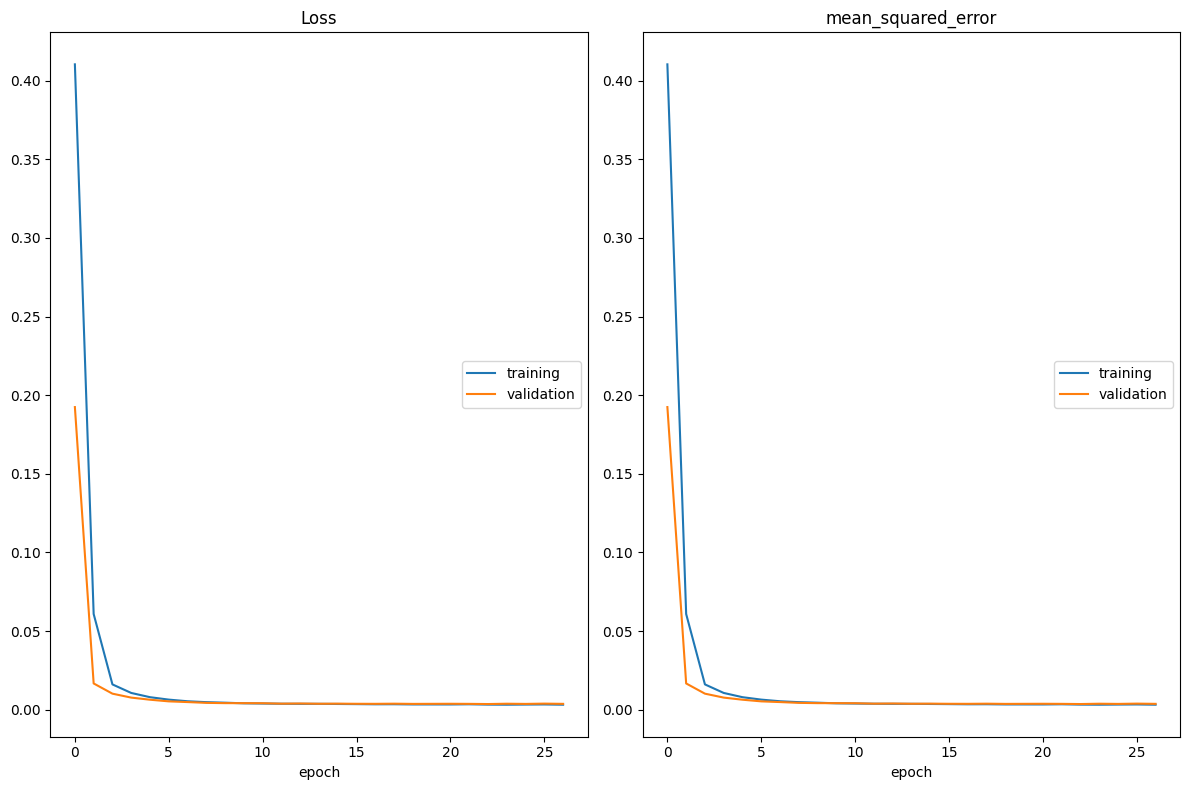

Loss
	training         	 (min:    0.003, max:    0.410, cur:    0.003)
	validation       	 (min:    0.004, max:    0.192, cur:    0.004)
mean_squared_error
	training         	 (min:    0.003, max:    0.410, cur:    0.003)
	validation       	 (min:    0.004, max:    0.192, cur:    0.004)
4/4 [==============================] - 0s 2ms/step

Root Mean Square Error
Training RMSE = 0.056006211374281106
Test RMSE = 0.07161789472508623

R2 Score
Training R^2 = 0.8454372862668447
Test R^2 = 0.7128940003138258


In [18]:
model = Sequential()

input_layer = Input(shape=(X_train.shape[1]))
model.add(input_layer)

activ_func_name = 'relu' # 'relu', 'elu', 'leaky_relu', 'linear'
nr_layers = 3
drop_out=False
hidden_num_nodes = X_train.shape[1]*2

# Hidden layers
for _ in range(nr_layers):
    model.add(Dense(units=hidden_num_nodes, 
        activation=activ_func_name, 
        kernel_initializer='normal', 
        kernel_regularizer=regularizers.L2(1e-6), 
        bias_regularizer=regularizers.L2(1e-6), 
        activity_regularizer=regularizers.L2(1e-6)))
    if drop_out:
        model.add(Dropout(0.25))

# Output layer
model.add(Dense(1))
model.add(Activation('linear'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

es_callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=3)
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[es_callback, PlotLossesKeras()],
          verbose=0)

y_predicted_train = model.predict(X_train_valid)
train_mse = mean_squared_error(y_train_valid, y_predicted_train)
train_r2 = r2_score(y_train_valid, y_predicted_train)

y_predicted_test = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_predicted_test)
test_r2 = r2_score(y_test, y_predicted_test)

print("\nRoot Mean Square Error")
print("Training RMSE =", np.sqrt(train_mse))
print("Test RMSE =", np.sqrt(test_mse))

print("\nR2 Score")
print("Training R^2 =", train_r2)
print("Test R^2 =", test_r2)